In [245]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm


# Classification with Naive Bayes Classifiers

In [246]:
class Fruit( object ):
    
    def __init__(self, color, diameter, acidity, price, is_a):
        self.color=color
        self.diameter=diameter
        self.acidity=acidity
        self.price=price
        self.is_a=is_a
    
    def getFeaturesDict(self): return {"color": self.color, "diameter": self.diameter, "acidity":self.acidity, "price": self.price}
    
    def getType(self): return self.is_a
        

In [280]:
# Colors: 1 red, 2 green, 3 yellow

myFruits = [Fruit(1.1,    10,  4,   1.09, "Apple"),
            Fruit(1.2,    12,  4.2, 1.19, "Apple"),
            Fruit(2.1,    8,   7,   1.09, "Apple"),
            Fruit(2.2,    3,   8,   0.49, "Lemon"),
            Fruit(2.9,    4,   7,   0.79, "Lemon"),
            Fruit(3.0,    2.7, 9.1, 0.69, "Lemon"),
            Fruit(1.6,    6,   2,   2.09, "Tomato"),
            Fruit(1.1,    6.2, 1.1, 2.19, "Tomato"),
            Fruit(2.0,    5.1, 4.0, 2.29, "Tomato"),
            Fruit(1.1,    11,  3.8, 0.90, "Apple"),
            Fruit(1.2,    9,   3.2, 1.29, "Apple"),
            Fruit(2.7,    7.1, 6.1, 1.43, "Apple"),
            Fruit(2.9,    3,   9.2, 0.69, "Lemon"),
            Fruit(3.0,    3.2, 7.1, 0.80, "Lemon"),
            Fruit(1.4,    6.5, 1.1, 1.89, "Tomato"),
            Fruit(1.1,    6.1, 1.2, 2.39, "Tomato")]


In [375]:


class NaiveBayesOfFruits( object ):
 
    def _distributionProbFunction(self,FruitType, Property):
        # Return the result of evaluating a Normal distribution of:
        #   mean equal to the mean of the property for this type of fruit
        #   std  equal to the std  of the property for this type of fruit
        return lambda x: norm.pdf( x, self.cmean[FruitType][Property],self.cstdv[FruitType][Property] )
        
    def __init__(self, myFruits):
        self.myFruits = myFruits
 
        self.FruitTypes = {}
        for fruit in self.myFruits:
            if fruit.getType() in self.FruitTypes.keys():
                self.FruitTypes[fruit.getType()] += 1
            else: self.FruitTypes[fruit.getType()] = 1
 
        self.probl = {}
        self.N = len(self.myFruits[0].getFeaturesDict())
        self.properties = list(self.myFruits[0].getFeaturesDict().keys())
        self.cmean = {}
        self.cstdv = {}
        self.prob = {}
        
        for fruitType in self.FruitTypes.keys():
            # The amount of fruits of each type that I have in my "training" dataset
            self.probl[fruitType] = self.FruitTypes[fruitType]/len(self.myFruits)
            
            # I will store the mean, std, and normal probabiblity function,
            # of each property for each type of fruit
            self.cmean[fruitType] = {} #[0 for i in range(self.N)]
            self.cstdv[fruitType] = {} #[0 for i in range(self.N)]
            self.prob[fruitType] = {} #[0 for i in range(self.N)]
            
            # Then, for each property
            for i, prop in enumerate(self.properties):
                # Make a numpy array taking the list of the read properties
                xi = np.array([float(e.getFeaturesDict()[prop]) for e in self.myFruits if e.getType() == fruitType])
                
                # Fullfill the mean with the mean, the std with the std and the prob with the probability function
                self.cmean[fruitType][prop] = xi.mean()
                self.cstdv[fruitType][prop] = xi.std()
                self.prob[fruitType][prop] = self._distributionProbFunction(fruitType,prop)

    def predict(self, X):
        p = {}
        
        # In the moment of predicting I have the probabilities of each feature of belonging to each class.
        for fruitType in self.FruitTypes.keys():
            vectorToMultiply = [self._distributionProbFunction(fruitType,prop)(X[i]) 
                                    for i, prop in enumerate(self.properties)
                                    if self._distributionProbFunction(fruitType,prop)(X[i]) != 0.0 ]
            cp = np.prod( vectorToMultiply )
            
            p[fruitType] = self.probl[fruitType]*cp
            
        results = [(p[fruitType],fruitType) for fruitType in self.FruitTypes.keys()]
        results.sort()
        return results[-1][1], results[-1][0]/sum([r[0] for r in results])

    def plotDistributions(self):
        for i, prop in enumerate(self.properties):
            nprops=len(range(self.N))
            rows = int(nprops/2)+int(nprops%2)
            plt.subplot(rows,2,i+1)
            for fruitType in list(self.FruitTypes.keys()):
                mean = self.cmean[fruitType][prop]
                var = self.cstdv[fruitType][prop]
                x= np.linspace(mean-4*var,mean+4*var,200)
                xmin,xmax=plt.xlim()
                plt.xlim(min(xmin,mean-3*var),max(xmax,mean+3*var))
                plt.title(self.properties[i])
                
                self.prob[fruitType][prop] = self._distributionProbFunction(fruitType,prop)

                plt.plot(x,self.prob[fruitType][prop](x), label = fruitType)
                leg = plt.legend(loc="upper left")
                leg.get_frame().set_alpha(0.7)
        plt.show()
        
    def __str__(self):
        s = 'Gaussian Naive Bayes Model:\n'
        for l in self.FruitTypes.keys():
            s+= ' P(%s) = %.3f\n'%(l, self.probl[l])
            for i,prop in enumerate(self.properties):
                s+= '  E(%s|%s) = %.3f\n'%(self.properties[i], l, self.cmean[l][prop])
                s+= '  VAR(%s|%s) = %.3f\n'%(self.properties[i], l, self.cstdv[l][prop]**2)
                s+= '\n'
        return s.strip()


In [376]:
myNBC = NaiveBayesOfFruits(myFruits)

In [377]:
print(myNBC.probl)

{'Apple': 0.375, 'Lemon': 0.3125, 'Tomato': 0.3125}


In [378]:
print(myNBC)

Gaussian Naive Bayes Model:
 P(Lemon) = 0.312
  E(price|Lemon) = 0.692
  VAR(price|Lemon) = 0.012

  E(color|Lemon) = 2.800
  VAR(color|Lemon) = 0.092

  E(acidity|Lemon) = 8.080
  VAR(acidity|Lemon) = 0.886

  E(diameter|Lemon) = 3.180
  VAR(diameter|Lemon) = 0.194

 P(Apple) = 0.375
  E(price|Apple) = 1.165
  VAR(price|Apple) = 0.028

  E(color|Apple) = 1.567
  VAR(color|Apple) = 0.379

  E(acidity|Apple) = 4.717
  VAR(acidity|Apple) = 1.841

  E(diameter|Apple) = 9.517
  VAR(diameter|Apple) = 2.835

 P(Tomato) = 0.312
  E(price|Tomato) = 2.170
  VAR(price|Tomato) = 0.030

  E(color|Tomato) = 1.440
  VAR(color|Tomato) = 0.114

  E(acidity|Tomato) = 1.880
  VAR(acidity|Tomato) = 1.238

  E(diameter|Tomato) = 5.980
  VAR(diameter|Tomato) = 0.222


In [379]:
# The order of the properties is not the same than in the constructor but the one given 
# by the enumerate: price, color, acidity, diameter.
myNBC.predict([0.692, 2.800, 8.080, 3.480])

('Lemon', 0.999999983341401)

In [380]:
myNBC.predict([1.7, 1.5, 3.0, 7.0])

('Tomato', 0.908551857471846)

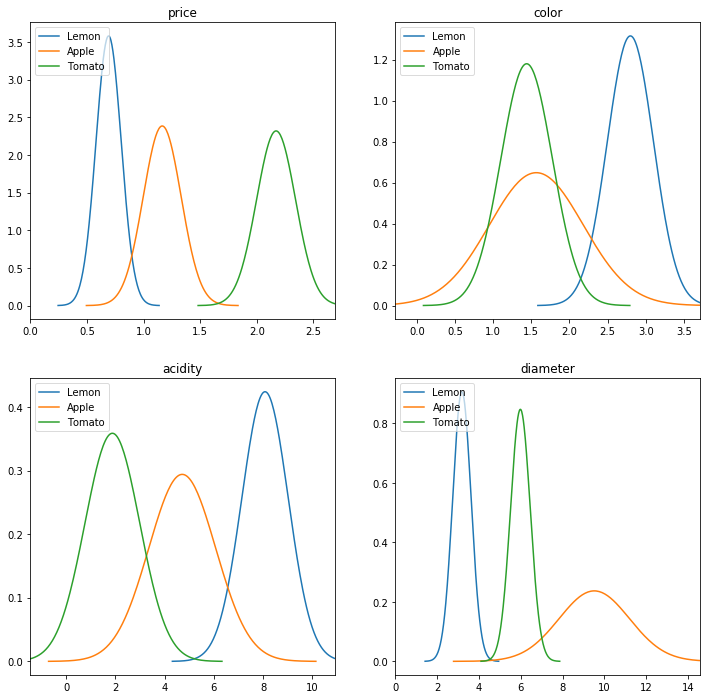

In [381]:
from IPython.core.pylabtools import figsize
figsize(12,12)
myNBC.plotDistributions()

# Clusterization with K-means

In [349]:
import math

def vector_euclidian_distance(feat_one, feat_two):
    squared_distance = 0
    #Assuming correct input to the function where the lengths of two features are the same
    for i in range(len(feat_one)):
            squared_distance += (feat_one[i] - feat_two[i])**2
    ed = math.sqrt(squared_distance)
    return ed

class K_Means:

    def __init__(self, k =3, tolerance = 0.0001, max_iterations = 500):
        self.k = k
        self.tolerance = tolerance
        self.max_iterations = max_iterations
    

    def fit(self, data):
        #initialize the centroids, the first 'k' elements in the dataset will be our initial centroids
        self.centroids = [None for _ in range(self.k)]
        for i in range(self.k):
            self.centroids[i] = data[i]

        for i in range(self.max_iterations):
            self.classes = {c:[] for c in range(self.k)}
            for i in range(self.k):
                self.classes[i] = []

                #find the distance between the point and cluster; choose the nearest centroid
                for features in data:
                    distances = [vector_euclidian_distance(features, self.centroids[centroid]) for centroid in range(len(self.centroids))]
                    classification = distances.index(min(distances))
                    self.classes[classification].append(features)

            previous = dict(self.centroids)

            #average the cluster datapoints to re-calculate the centroids
            for classification in self.classes:
                self.centroids[classification] = np.average(self.classes[classification], axis = 0)


In [350]:
from scipy.stats import norm

colors = 10*["r", "g", "c", "b", "k"]

Centroid: [0.49718878 0.94650865]
Centroid: [-1.11302169  0.05183639]
Centroid: [ 0.41952236 -0.88423244]


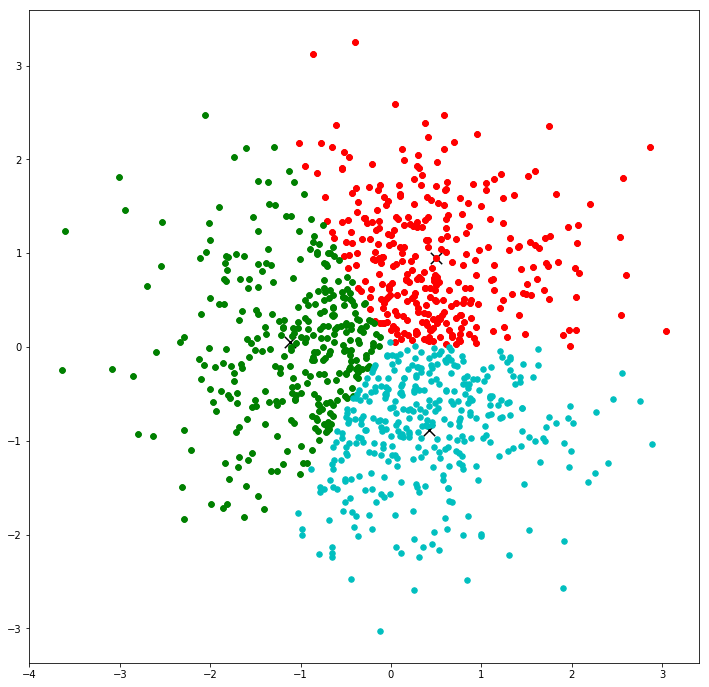

In [351]:

X = norm.rvs(size=1000)
Y = norm.rvs(size=1000)
Z = list(zip(X,Y))

km = K_Means(3)
km.fit(Z)


for centroid in km.centroids:
    print ("Centroid:", centroid)
    plt.scatter(centroid[0], centroid[1], s = 130, color="black", marker = "x")
    
for classification in km.classes:
    color = colors[classification]
    for features in km.classes[classification]:
        plt.scatter(features[0], features[1], color = color,s = 30)

In [352]:

X = list(norm.rvs(size=500)) + list(norm.rvs(size=500,loc=40,scale=2))
Y = norm.rvs(size=1000)
Z = list(zip(X,Y))

km = K_Means(3)
km.fit(Z)


for centroid in km.centroids:
    print ("Centroid:", centroid)
    plt.scatter(centroid[0], centroid[1], s = 130, color="black", marker = "x")
    
for classification in km.classes:
    color = colors[classification]
    for features in km.classes[classification]:
        plt.scatter(features[0], features[1], color = color,s = 30)

/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: invalid index to scalar variable.